In [33]:
import numpy as np
import pandas as pd
import pandasql as pdsql
import datetime as dt
import seaborn as sna
from scipy import stats
sna.set()
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.notebook_repr_html=False

In [34]:
!ls 

Ab Homework solution.ipynb
DSChallenge-TakeHome.pdf
Session 4 AB test and experiment design.docx
attempt1.ipynb
takehome_assignments.csv
takehome_contacts.csv
yiceluo_hw.docx


In [35]:
treatment_control_lookup=pd.read_csv('./takehome_assignments.csv')

In [36]:
pd.read_csv?

In [37]:
contracts=pd.read_csv('./takehome_contacts.csv',\
                      parse_dates=['ts_reply_at_first','ts_interaction_first','ts_accepted_at_first','ts_booking_at']) 

In [38]:
#treatment_control_lookup.head(2)
#print type(contracts.ts_interaction_first[1])
treatment_control_lookup.count()

id_user    10000
ab         10000
dtype: int64

In [39]:
treatment_control_lookup=treatment_control_lookup.drop_duplicates()
treatment_control_lookup.count()

id_user    9487
ab         9487
dtype: int64

In [40]:
treatment_control_lookup=pdsql.sqldf("select distinct id_user, ab, count(distinct ab) as  ab_cnt from treatment_control_lookup group by id_user",locals())
treatment_control_lookup.ab_cnt.value_counts()

1    8701
2     393
Name: ab_cnt, dtype: int64

In [41]:
print (8701+393*2)

9487


In [42]:
unique_group_id=treatment_control_lookup[treatment_control_lookup.ab_cnt==1][['id_user','ab']]
unique_group_id.count()

id_user    8701
ab         8701
dtype: int64

In [43]:
contracts.count()

id_guest                  10000
id_host                   10000
id_listing                10000
ts_interaction_first      10000
ts_reply_at_first         10000
ts_accepted_at_first      10000
ts_booking_at             10000
dim_contact_channel       10000
m_first_message_length     9883
dtype: int64

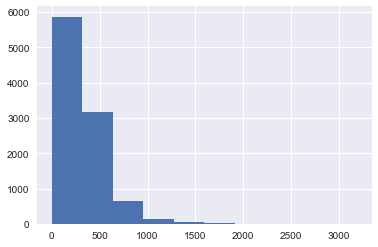

In [44]:
contracts.m_first_message_length.hist()

In [45]:
contracts.head(2)

                               id_guest                               id_host  \
0  f966752c-8533-48b2-af6f-8c6797d2b247  4405ab66-1c68-449b-abd9-1ad1892a6c4d   
1  873f93fb-234c-4cfb-83c7-27ff0e582a8e  aa41b57b-e29f-4c95-bf27-48f27519e419   

                             id_listing ts_interaction_first  \
0  fe07e0c4-c317-44bc-a82d-5b599a248049  2013-01-01 23:04:00   
1  d47717da-315a-42c2-8888-9b7d4bea8829  2013-01-02 00:21:00   

  ts_reply_at_first ts_accepted_at_first ts_booking_at dim_contact_channel  \
0           15:23.0                  nan           nan          contact_me   
1           38:31.0                  nan           nan          contact_me   

   m_first_message_length  
0                   230.0  
1                    98.0  

In [46]:
unique_group_id.head()

                                id_user         ab
0  0000d66b-1872-4605-9244-24d5936e221c    control
2  000df180-89b7-45c4-a738-15f6962a101d    control
3  0018de9a-7ef1-4c02-ab10-c85b8d44bcdf  treatment
4  001b411e-56cd-4b6d-a6de-92360d6d367e  treatment
5  001ef343-7d2e-4279-8ca5-4fb28d1cb1f5  treatment

In [47]:
contracts= (pd.merge(left=contracts,
                 right=unique_group_id,
                 left_on=['id_guest'],
                 right_on=['id_user'],
                 how='left'
                )
         )
contracts.count()
contracts['Experiment group']=contracts.ab
#contracts.drop_duplicates().count() no duplicates

In [48]:
contracts.ab.value_counts(dropna=False)

treatment    4554
control      4550
NaN           896
Name: ab, dtype: int64

In [49]:
contracts['m_first_message_length']=contracts.m_first_message_length.fillna(value=0)
contracts.m_first_message_length.describe()

count    10000.000000
mean       320.662500
std        234.797876
min          0.000000
25%        163.000000
50%        270.000000
75%        417.000000
max       3182.000000
Name: m_first_message_length, dtype: float64

Experiment group
dim_contact_channel
Experiment group  dim_contact_channel
control           contact_me             3648
                  book_it                 880
                  instant_booked           22
treatment         contact_me             3642
                  book_it                 890
                  instant_booked           22
Name: dim_contact_channel, dtype: int64


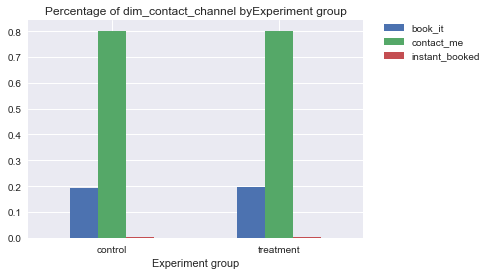

In [50]:
#plot percentage of 
grp_col='Experiment group'
col='dim_contact_channel'
print grp_col
print col
grouped_contracts=contracts.groupby([grp_col])
print grouped_contracts[col].value_counts()
grouped_contracts[col].value_counts(2).unstack().plot(kind="bar",rot='horizontal',\
                                    title='Percentage of ' + col + ' by' + grp_col )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Experiment group  dim_contact_channel
control           contact_me             3648
                  book_it                 880
                  instant_booked           22
treatment         contact_me             3642
                  book_it                 890
                  instant_booked           22
Name: dim_contact_channel, dtype: int64


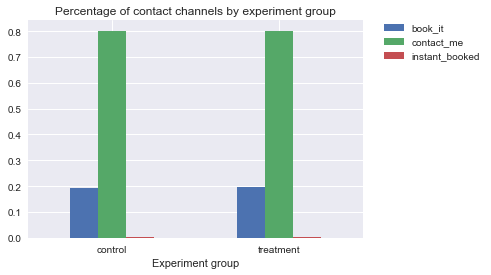

In [51]:
grp_col=['Experiment group']
grouped_contracts=contracts.groupby(grp_col)
print grouped_contracts.dim_contact_channel.value_counts()
grouped_contracts.dim_contact_channel.value_counts(2).unstack().plot(kind="bar",rot='horizontal',\
                                    title='Percentage of contact channels by experiment group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#about same amount of people choose those three contact channel among treatment and control group

# Define some binary outcomes and check the proportion of them between treatment Vs control group

In [57]:
grouped_contracts['replied'].value_counts()

Experiment group  replied
control           True       4550
treatment         True       4554
Name: replied, dtype: int64

In [56]:
contracts['replied']=contracts.ts_reply_at_first.notnull()

In [ ]:
contracts['replied']

In [58]:
contracts['replied']=contracts.ts_reply_at_first.notnull()
contracts['accepted']=contracts.ts_accepted_at_first.notnull()
contracts['booked']=contracts.ts_booking_at.notnull()
contracts['messaged']=contracts.m_first_message_length.apply(lambda x: "messaged" if x>0.0 else "no message")
contracts['message_group']=contracts.m_first_message_length.apply(lambda x: "long message" if x>=140.0 else "short message")
binary_outcome=['replied','accepted','booked','messaged','message_group','dim_contact_channel']
for i in binary_outcome:
    print "Chi-square test of contingency table: " + i + " Vs treatment group"
    print "\n"
    print grouped_contracts[i].value_counts(2).unstack().fillna(0)
    print "\n"
    print grouped_contracts[i].value_counts().unstack().fillna(0)
    print "\n"
    print stats.chi2_contingency(grouped_contracts[i].value_counts().unstack().fillna(0))
    print "\n"
    print "\n"

Chi-square test of contingency table: replied Vs treatment group


replied           True
Experiment group      
control            1.0
treatment          1.0


replied           True
Experiment group      
control           4550
treatment         4554


(0.0, 1.0, 0, array([[ 4550.],
       [ 4554.]]))




Chi-square test of contingency table: accepted Vs treatment group


accepted          True
Experiment group      
control            1.0
treatment          1.0


accepted          True
Experiment group      
control           4550
treatment         4554


(0.0, 1.0, 0, array([[ 4550.],
       [ 4554.]]))




Chi-square test of contingency table: booked Vs treatment group


booked            True
Experiment group      
control            1.0
treatment          1.0


booked            True
Experiment group      
control           4550
treatment         4554


(0.0, 1.0, 0, array([[ 4550.],
       [ 4554.]]))




Chi-square test of contingency table: messaged Vs treatment group


messa

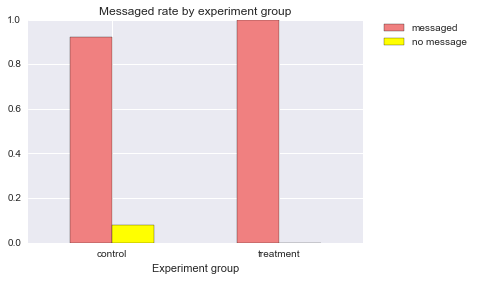

In [16]:
grouped_contracts['messaged'].value_counts(2).unstack().fillna(0).plot(kind="bar",color=['lightcoral','yellow'],rot='horizontal',\
                                    title='Messaged rate by experiment group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

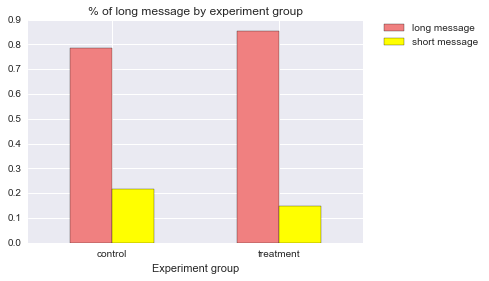

In [17]:
grouped_contracts['message_group'].value_counts(2).unstack().fillna(0).plot(kind="bar",color=['lightcoral','yellow'],rot='horizontal',\
                                    title='% of long message by experiment group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


# Conclusion: 

1) The treatment let user more likely to submit a message to host 
2) The treatment let user more likely to write long message to host
3) Reply rate, acceptance rate, booking rate and contact channel does not have significant difference between the two experiment groups.

## Define continuous outcomes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f2ff650>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11036fe90>], dtype=object)

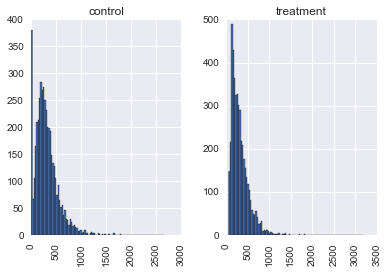

In [18]:
contracts.m_first_message_length.hist(bins=100, by=contracts.ab)

In [19]:
#contracts['reply_time']=(contracts.ts_reply_at_first-contracts.ts_interaction_first)
contracts['reply_time_h']=(contracts.ts_reply_at_first-contracts.ts_interaction_first)/np.timedelta64(1, 'h')
contracts['accept_time_h']=(contracts.ts_accepted_at_first-contracts.ts_interaction_first)/np.timedelta64(1, 'h')
contracts['booking_time_h']=(contracts.ts_booking_at-contracts.ts_interaction_first)/np.timedelta64(1, 'h')

In [20]:
contracts[['reply_time_h','accept_time_h','booking_time_h','m_first_message_length']].describe()

       reply_time_h  accept_time_h  booking_time_h  m_first_message_length
count   8571.000000    3363.000000     2171.000000            10000.000000
mean      48.183884      27.970940       43.954933              320.662500
std      414.163084     308.251372      385.898037              234.797876
min       -0.027778      -0.027778       -0.027778                0.000000
25%        0.545972       0.406111        0.761250              163.000000
50%        3.873889       2.920833        6.024167              270.000000
75%       16.551389      14.262639       23.905833              417.000000
max    14026.655556   16102.172500    16102.172500             3182.000000

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


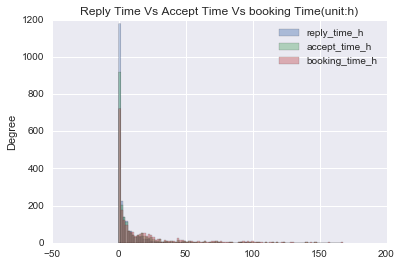

In [21]:
contracts[['reply_time_h','accept_time_h','booking_time_h']][contracts.reply_time_h<=168][contracts.accept_time_h<=168][contracts.booking_time_h<=168].plot(kind='hist',\
                                                                   bins=100,alpha=0.4,title='Reply Time Vs Accept Time Vs booking Time(unit:h)')

In [22]:
print contracts.reply_time_h[contracts.reply_time_h<0].count() 
print contracts.accept_time_h[contracts.accept_time_h<0].count() 
print contracts.booking_time_h[contracts.booking_time_h<0].count() 
# there are small number of small negative values for those 3 times, since the value is not too bad, 
#I will just change them to 0, assuming it's casued by the small difference of time on user's computer.

155
110
88


In [23]:
#change those negative delta time (h) to 0 
contracts.reply_time_h=contracts.reply_time_h.apply(lambda x: 0 if x<0 else x)
contracts.accept_time_h=contracts.accept_time_h.apply(lambda x: 0 if x<0 else x)
contracts.booking_time_h=contracts.booking_time_h.apply(lambda x: 0 if x<0 else x)

In [24]:
#Chenck the frequency of  extreamly large value for those 3 time variables, since the freq is small, I decide to drop
#those records when I look at the distribution of time
print contracts.reply_time_h[contracts.reply_time_h>168].count() #168 hour is one week
print contracts.accept_time_h[contracts.accept_time_h>168].count() 
print contracts.booking_time_h[contracts.booking_time_h>168].count()

293
66
86


## Do t-test for continous vairables

In [25]:
grouped_contracts.describe()

                        accept_time_h   accepted     booked  booking_time_h  \
Experiment group                                                              
control          count    1595.000000       4550       4550     1039.000000   
                 mean       36.623934  0.3505495  0.2283516       53.197732   
                 std       436.569502  0.4771945  0.4198165      536.715799   
                 min         0.000000      False      False        0.000000   
                 25%         0.365000          0          0        0.690833   
                 50%         2.775833          0          0        5.423611   
                 75%        14.629861          1          0       23.075000   
                 max     16102.172500       True       True    16102.172500   
treatment        count    1561.000000       4554       4554     1038.000000   
                 mean       18.117475  0.3427756  0.2279315       31.603864   
                 std        70.148085  0.4746893  0.

In [26]:
from scipy.stats import ttest_ind
t, p = ttest_ind(contracts.m_first_message_length[contracts.ab=="treatment"], \
contracts.m_first_message_length[contracts.ab=="control"], equal_var=False)
print "t-test for m_first_message_length between treatment and control group: t = %g  p = %g" % (t, p)

t-test for m_first_message_length between treatment and control group: t = 1.58869  p = 0.112166


### no significant difference of average message length in the two groups at 95% confidence level.

In [27]:
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
#lm=ols(' m_first_message_length ~ C(ab)', data=contracts).fit() 
#lm.pvalues

In [28]:
time_var_list=['reply_time_h','accept_time_h','booking_time_h']
for i in time_var_list:
    for hours in [1,2,3,6,12,24,48,168]:
        print "if we only use records that reply/accept/booking time within " + str(hours) +" hours"
        t, p = ttest_ind(contracts[i][contracts[i]<=hours][contracts.ab=="treatment"], \
        contracts[i][contracts[i]<=hours][contracts.ab=="control"], equal_var=False)
        print "t-test for " + i + " between treatment and control group: t = %g  p = %g" % (t, p)

if we only use records that reply/accept/booking time within 1 hours
t-test for reply_time_h between treatment and control group: t = 0.808903  p = 0.418648
if we only use records that reply/accept/booking time within 2 hours
t-test for reply_time_h between treatment and control group: t = -0.71885  p = 0.472286
if we only use records that reply/accept/booking time within 3 hours
t-test for reply_time_h between treatment and control group: t = 0.107015  p = 0.914783
if we only use records that reply/accept/booking time within 6 hours
t-test for reply_time_h between treatment and control group: t = 0.151135  p = 0.879876
if we only use records that reply/accept/booking time within 12 hours
t-test for reply_time_h between treatment and control group: t = -0.0149512  p = 0.988072
if we only use records that reply/accept/booking time within 24 hours
t-test for reply_time_h between treatment and control group: t = 0.125274  p = 0.900311
if we only use records that reply/accept/booking time 

### Therefore, there is no significant difference of continous outcomes between the two experiment groups.

In [29]:
print contracts[contracts.ab.notnull()].message_group.value_counts()
print contracts[contracts.ab.isnull()].message_group.value_counts()
#although there are some records with missing value for treatment and control, those records can still be used in testing
#the impact of long message(>140) Vs not.

long message     7452
short message    1652
dtype: int64
long message     765
short message    131
dtype: int64


### Although in the homework description it says: We "required" the guest to write a message that's at least 140 characters long. But I still see lots of m_first_message_length value less than 140 in the treatment group. So I think the experiment is conducted in a way that only "ask" but not "force" user to submit a message that's more than 140 characters long. Even the first message is less than 140 characters, the user still can submit the inqury.Therefore, it might worth to check the acceptance rate, response rate, booking rate for those people who send long message (if we define long message as more than 140 characters)no matter which group those users belong to. I only use those contact_me records since most of the users do not send long message when they use book it or instant book.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1111c6ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1120fb350>]], dtype=object)

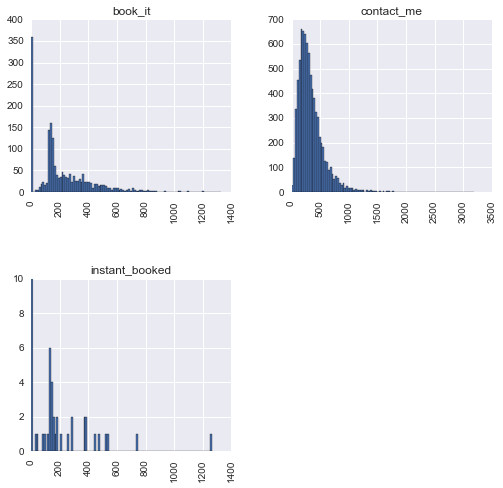

In [30]:
contracts.m_first_message_length.hist(bins=100, by=contracts.dim_contact_channel,figsize=(8,8))
#so basically this test only impact those people who book through "contact me" or "book_it"

In [31]:
grouped_by_long_message=contracts[contracts.dim_contact_channel=='contact_me'].groupby(['message_group'])
binary_outcome=['replied','accepted','booked']
for i in binary_outcome:
    print "Chi-square test of contingency table: " + i + " Vs message group"
    print grouped_by_long_message[i].value_counts(2).unstack().fillna(0)
    print stats.chi2_contingency(grouped_by_long_message[i].value_counts().unstack().fillna(0))
    print "\n"

Chi-square test of contingency table: replied Vs message group
                  True      False
message_group                    
long message   0.844721  0.155279
short message  0.841601  0.158399
(0.051246698799421286, 0.82090795273660155, 1, array([[ 5893.92177122,  1087.07822878],
       [  970.07822878,   178.92177122]]))


Chi-square test of contingency table: accepted Vs message group
                  False     True 
message_group                    
long message   0.717662  0.282338
short message  0.727589  0.272411
(0.43340444594508853, 0.51032314938832068, 1, array([[ 5019.79409594,  1961.20590406],
       [  826.20590406,   322.79409594]]))


Chi-square test of contingency table: booked Vs message group
                  False     True 
message_group                    
long message   0.862914  0.137086
short message  0.873803  0.126197
(0.90772072896585176, 0.34071990052045253, 1, array([[ 6034.74391144,   946.25608856],
       [  993.25608856,   155.74391144]]))




### No significant difference in reply rate, acceptance rate, booking rate between different message group.

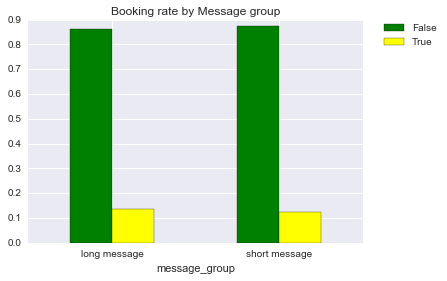

In [32]:
grouped_by_long_message['booked'].value_counts(2).unstack().fillna(0).plot(kind="bar",color=['g','yellow'],rot='horizontal',\
                                    title='Booking rate by Message group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

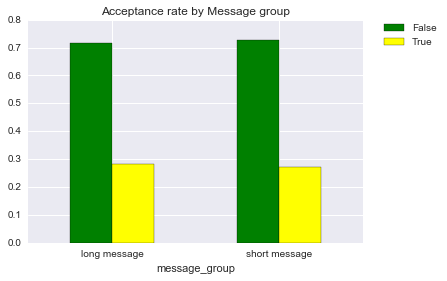

In [33]:
grouped_by_long_message['accepted'].value_counts(2).unstack().fillna(0).plot(kind="bar",color=['g','yellow'],rot='horizontal',\
                                    title='Acceptance rate by Message group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [34]:
grouped_by_long_message.describe()

                     accept_time_h   accepted     booked  booking_time_h  \
message_group                                                              
long message  count    1971.000000       6981       6981      957.000000   
              mean       40.068610  0.2823378  0.1370864       83.098130   
              std       397.931601  0.4501691  0.3439632      572.174252   
              min         0.000000      False      False        0.020833   
              25%         0.614028          0          0        5.018889   
              50%         4.205000          0          0       21.347500   
              75%        19.013056          1          0       53.455833   
              max     16102.172500       True       True    16102.172500   
short message count     313.000000       1149       1149      145.000000   
              mean       13.901254  0.2724108  0.1261967       30.657291   
              std        27.926292   0.445394  0.3322155       61.075757   
            

In [35]:
sub=contracts[contracts.dim_contact_channel=='contact_me']
time_var_list=['reply_time_h','accept_time_h','booking_time_h']
for i in time_var_list:
    for hours in [1,2,3,6,12,24,48,168]:
        print "if we only use records that " + i + " within " + str(hours) +" hours" 
        a=sub[sub[i]<=hours].groupby(['message_group'])
        print a[i].mean()
        t, p = ttest_ind(sub[i][sub[i]<=hours][sub.message_group=="long message"], \
        sub[i][sub[i]<=hours][sub.message_group=="short message"], equal_var=False)
        print "t-test for " + i + " between treatment and control group: t = %g  p = %g" % (t, p)

if we only use records that reply_time_h within 1 hours
message_group
long message     0.316254
short message    0.261351
Name: reply_time_h, dtype: float64
t-test for reply_time_h between treatment and control group: t = 3.41615  p = 0.000688791
if we only use records that reply_time_h within 2 hours
message_group
long message     0.581593
short message    0.542128
Name: reply_time_h, dtype: float64
t-test for reply_time_h between treatment and control group: t = 1.31729  p = 0.188235
if we only use records that reply_time_h within 3 hours
message_group
long message     0.837469
short message    0.776791
Name: reply_time_h, dtype: float64
t-test for reply_time_h between treatment and control group: t = 1.47576  p = 0.140456
if we only use records that reply_time_h within 6 hours
message_group
long message     1.593341
short message    1.275883
Name: reply_time_h, dtype: float64
t-test for reply_time_h between treatment and control group: t = 4.54614  p = 6.26136e-06
if we only use rec

## When user choose contact_me, long message does not make host reply faster and does not increase acceptance rate and booking rate.

In [36]:
grouped_by_long_message=contracts[contracts.dim_contact_channel=='book_it'].groupby(['message_group'])
binary_outcome=['replied','accepted','booked']
for i in binary_outcome:
    print "Chi-square test of contingency table: " + i + " Vs message group"
    print grouped_by_long_message[i].value_counts(2).unstack().fillna(0)
    print stats.chi2_contingency(grouped_by_long_message[i].value_counts().unstack().fillna(0))
    print "\n"

Chi-square test of contingency table: replied Vs message group
                  True      False
message_group                    
long message   0.916735  0.083265
short message  0.898858  0.101142
(1.3884841725612387, 0.23866125343856337, 1, array([[ 1104.72015334,   108.27984666],
       [  558.27984666,    54.72015334]]))


Chi-square test of contingency table: accepted Vs message group
                  True      False
message_group                    
long message   0.558120  0.441880
short message  0.584013  0.415987
(1.0089306770759894, 0.31515915202425193, 1, array([[ 687.54381161,  525.45618839],
       [ 347.45618839,  265.54381161]]))


Chi-square test of contingency table: booked Vs message group
                  True      False
message_group                    
long message   0.553174  0.446826
short message  0.577488  0.422512
(0.88137622787349623, 0.34782501862133575, 1, array([[ 680.90087623,  532.09912377],
       [ 344.09912377,  268.90087623]]))




In [37]:
#so people who use instant_booked or book_it tends to have a much  lower chance to send long message

In [38]:
contracts.columns

Index([u'id_guest', u'id_host', u'id_listing', u'ts_interaction_first',
       u'ts_reply_at_first', u'ts_accepted_at_first', u'ts_booking_at',
       u'dim_contact_channel', u'm_first_message_length', u'id_user', u'ab',
       u'Experiment group', u'replied', u'accepted', u'booked', u'messaged',
       u'message_group', u'reply_time_h', u'accept_time_h', u'booking_time_h'],
      dtype='object')

dim_contact_channel               
book_it              long message     1213
                     short message     613
contact_me           long message     6981
                     short message    1149
instant_booked       long message       23
                     short message      21
dtype: int64
dim_contact_channel               
book_it              long message     0.664294
                     short message    0.335706
contact_me           long message     0.858672
                     short message    0.141328
instant_booked       long message     0.522727
                     short message    0.477273
dtype: float64


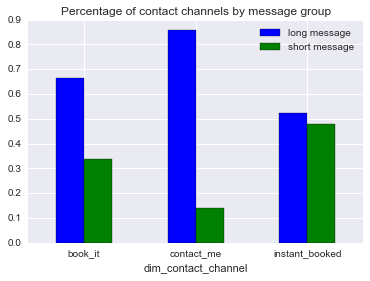

In [39]:
b=contracts.groupby(['dim_contact_channel'])
print b.message_group.value_counts()
print b.message_group.value_counts(2)
b.message_group.value_counts(2).unstack().plot(kind="bar",rot='horizontal',\
                                    title='Percentage of contact channels by message group')